In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
import numpy as np


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_lfw_people

In [ ]:
tf.test.is_built_with_cuda()

True

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=90, resize=0.4)
X, y = lfw_people.images, lfw_people.target

In [ ]:
X = X / 255.0 # Normalize pixel values to be between 0 and 1



In [ ]:
y

array([2, 3, 1, ..., 4, 2, 4])

In [ ]:
X.shape

(1140, 50, 37)

In [ ]:
X.shape[1] * X.shape[2] #Number of features (pixels)

1850

In [ ]:
len(np.unique(y)) #Number of unique individuals

5

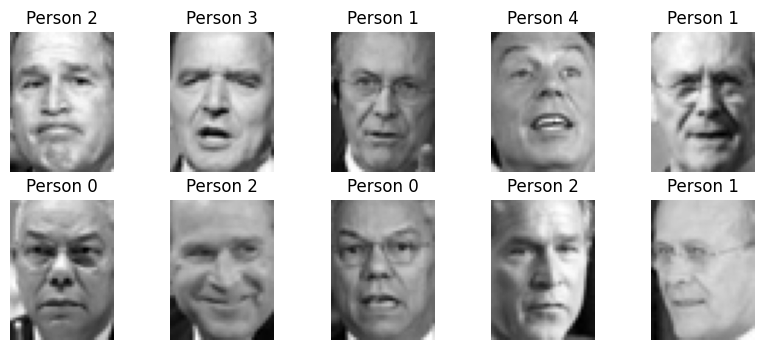

In [ ]:
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i], cmap='gray')
    plt.title(f'Person {y[i]}')
    plt.axis('off')
plt.show()

Text(0, 0.5, 'Frequency')

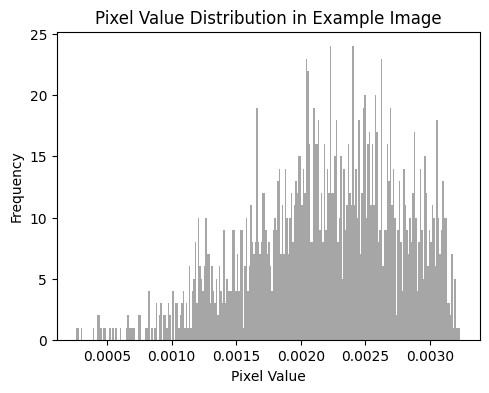

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(X[0].ravel(), bins=256, color='gray', alpha=0.7)
plt.title('Pixel Value Distribution in Example Image')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
label_encoder = LabelEncoder()
all_labels = np.concatenate((y_train, y_test))
all_labels_encoded = label_encoder.fit_transform(all_labels)

y_train_encoded = all_labels_encoded[:len(y_train)]
y_test_encoded = all_labels_encoded[len(y_train):]


In [ ]:


# Create a simple CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2],1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(5749, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)


print("X_train shape:", X_train_reshaped.shape)
print("X_test shape:", X_test_reshaped.shape)

X_train shape: (912, 50, 37, 1)
X_test shape: (228, 50, 37, 1)


In [ ]:
history = model.fit(X_train_reshaped, y_train_encoded, validation_data=(X_test_reshaped, y_test_encoded), epochs=10, batch_size=32)


Epoch 1/10
29/29 [==============================] - 2s 28ms/step - loss: 1.4495 - accuracy: 0.4572 - val_loss: 1.4093 - val_accuracy: 0.4649
Epoch 2/10
29/29 [==============================] - 0s 9ms/step - loss: 1.4242 - accuracy: 0.4649 - val_loss: 1.4038 - val_accuracy: 0.4649
Epoch 3/10
29/29 [==============================] - 0s 10ms/step - loss: 1.4207 - accuracy: 0.4649 - val_loss: 1.4225 - val_accuracy: 0.4649
Epoch 4/10
29/29 [==============================] - 0s 10ms/step - loss: 1.4168 - accuracy: 0.4649 - val_loss: 1.4008 - val_accuracy: 0.4649
Epoch 5/10
29/29 [==============================] - 0s 11ms/step - loss: 1.4127 - accuracy: 0.4649 - val_loss: 1.4034 - val_accuracy: 0.4649
Epoch 6/10
29/29 [==============================] - 0s 10ms/step - loss: 1.4115 - accuracy: 0.4649 - val_loss: 1.4055 - val_accuracy: 0.4649
Epoch 7/10
29/29 [==============================] - 0s 10ms/step - loss: 1.4143 - accuracy: 0.4649 - val_loss: 1.4056 - val_accuracy: 0.4649
Epoch 8/10
29/

In [ ]:
X_test_reshaped = np.expand_dims(X_test, axis=-1)

test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_encoded)


8/8 [==============================] - 0s 5ms/step - loss: 1.4045 - accuracy: 0.4649


In [ ]:
test_accuracy

0.4649122953414917

In [ ]:
model_aug = models.Sequential([
   layers.Conv2D(64, (3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2],1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

In [ ]:
model_aug.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
history_aug = model_aug.fit(
    datagen.flow(X_train_reshaped, y_train_encoded, batch_size=32),
    validation_data=(X_test, y_test_encoded),
    epochs=20
)


Epoch 1/20
29/29 [==============================] - 3s 32ms/step - loss: 2.3427 - accuracy: 0.4594 - val_loss: 2.2246 - val_accuracy: 0.4649
Epoch 2/20
29/29 [==============================] - 1s 17ms/step - loss: 2.0821 - accuracy: 0.4649 - val_loss: 1.9946 - val_accuracy: 0.4649
Epoch 3/20
29/29 [==============================] - 1s 18ms/step - loss: 1.9560 - accuracy: 0.4649 - val_loss: 1.9060 - val_accuracy: 0.4649
Epoch 4/20
29/29 [==============================] - 1s 20ms/step - loss: 1.8827 - accuracy: 0.4649 - val_loss: 1.8350 - val_accuracy: 0.4649
Epoch 5/20
29/29 [==============================] - 1s 18ms/step - loss: 1.8170 - accuracy: 0.4649 - val_loss: 1.7738 - val_accuracy: 0.4649
Epoch 6/20
29/29 [==============================] - 1s 18ms/step - loss: 1.7591 - accuracy: 0.4649 - val_loss: 1.7238 - val_accuracy: 0.4649
Epoch 7/20
29/29 [==============================] - 1s 19ms/step - loss: 1.7151 - accuracy: 0.4649 - val_loss: 1.6810 - val_accuracy: 0.4649
Epoch 8/20
29

In [ ]:
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

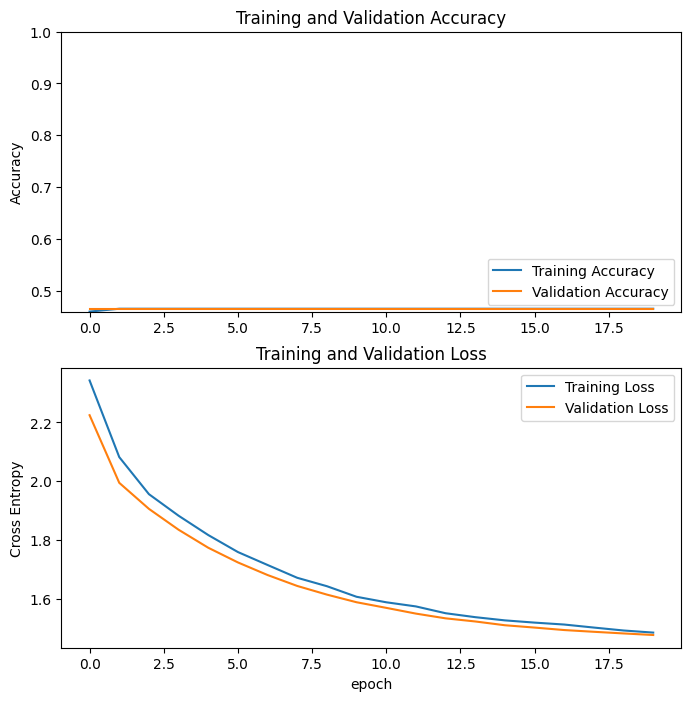

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model_aug.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model_aug.layers))

# Fine-tune from this layer onwards
fine_tune_at = 2

# Freeze all the layers before the `fine_tune_at` layer
for layer in model_aug.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  10


In [ ]:

model_aug.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001),
              metrics=['accuracy'])

In [ ]:
model_aug.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 48, 35, 64)        640       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 24, 17, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 22, 15, 128)       73856     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 11, 7, 128)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 9, 5, 256)         295168    
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 4, 2, 256)        

In [ ]:
len(model_aug.trainable_variables)

8

In [ ]:
history_fine= model_aug.fit(
     datagen.flow(X_train_reshaped, y_train_encoded, batch_size=32),
     epochs=30,
     initial_epoch=history_aug.epoch[-1],
     validation_data=(X_test, y_test_encoded)
)

Epoch 20/30
29/29 [==============================] - 2s 23ms/step - loss: 1.4831 - accuracy: 0.4649 - val_loss: 1.4768 - val_accuracy: 0.4649
Epoch 21/30
29/29 [==============================] - 1s 19ms/step - loss: 1.4844 - accuracy: 0.4649 - val_loss: 1.4765 - val_accuracy: 0.4649
Epoch 22/30
29/29 [==============================] - 1s 19ms/step - loss: 1.4885 - accuracy: 0.4649 - val_loss: 1.4763 - val_accuracy: 0.4649
Epoch 23/30
29/29 [==============================] - 1s 18ms/step - loss: 1.4853 - accuracy: 0.4649 - val_loss: 1.4761 - val_accuracy: 0.4649
Epoch 24/30
29/29 [==============================] - 1s 19ms/step - loss: 1.4916 - accuracy: 0.4649 - val_loss: 1.4759 - val_accuracy: 0.4649
Epoch 25/30
29/29 [==============================] - 1s 18ms/step - loss: 1.4812 - accuracy: 0.4649 - val_loss: 1.4756 - val_accuracy: 0.4649
Epoch 26/30
29/29 [==============================] - 1s 18ms/step - loss: 1.4848 - accuracy: 0.4649 - val_loss: 1.4754 - val_accuracy: 0.4649
Epoch 

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

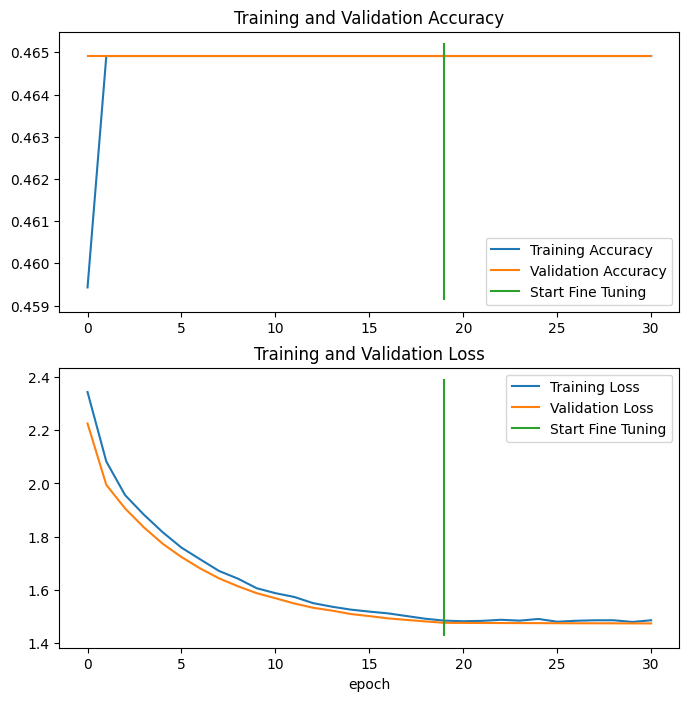

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.plot([20-1,20-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([20-1,20-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
X_test_reshaped = np.expand_dims(X_test, axis=-1)

test_loss, test_accuracy = model_aug.evaluate(X_test_reshaped, y_test_encoded)

8/8 [==============================] - 0s 4ms/step - loss: 1.4749 - accuracy: 0.4649


In [ ]:
model_aug.save('aug_training_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
